## Model Training ##

The second part of our project is about training models to estimate scoring and conceding probabilities, and deriving the action values from those.

First we will load the data. If you have not already you should run the 1_Loading_Data.ipynb file to retrieve the data and save it to a file, so that it can be loaded here.

In [321]:
import shap
import pandas as pd
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, brier_score_loss

df_model = pd.read_pickle("data/data_cleaned.pkl")

### Encoding ###

Some classification algorithms like logistic regression require us to encode categorical columns like action_type or body_part. So we will do this via one-hot encoding.

In [322]:
body_part_dummies = pd.get_dummies(df_model['body_part_name'], prefix='body_part_name')
action_type_dummies = pd.get_dummies(df_model['action_type'], prefix='action_type')

df_model = pd.concat([df_model, body_part_dummies, action_type_dummies], axis=1)

In [323]:
RANDOM_STATE = 10

### Estimating Probabilities ###

#### XG Boost Basic Model ####

Now we can train our first logistic regression model to try and predict the two labels based on our features.

In [324]:
features = ['distance_to_goal', 'angle_to_goal']

target = 'label_team_goal'

df_model = df_model.dropna(subset=features + [target])

X = df_model[features]
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y, random_state=RANDOM_STATE)

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    eval_metric='logloss',
    random_state=RANDOM_STATE
)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC AUC Score:", roc_auc_score(y_test, y_prob))
print("Brier Score:", brier_score_loss(y_test, y_prob))

y_prob_all = xgb_model.predict_proba(df_model[features])[:, 1]
df_model = df_model.copy()
df_model['predicted_goal_prob'] = y_prob_all

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    221395
           1       0.00      0.00      0.00      2513

    accuracy                           0.99    223908
   macro avg       0.49      0.50      0.50    223908
weighted avg       0.98      0.99      0.98    223908

ROC AUC Score: 0.7546726803139092
Brier Score: 0.010751168694599453


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

And analogously the same for the conceding probabilities.

In [325]:
features = ['distance_to_goal_own', 'angle_to_goal_own']

target_opponent = 'label_opponent_goal'

df_model = df_model.dropna(subset=features + [target_opponent])

X_opp = df_model[features]
y_opp = df_model[target_opponent]

X_train_opp, X_test_opp, y_train_opp, y_test_opp = train_test_split(
    X_opp, y_opp, test_size=0.5, stratify=y_opp, random_state=RANDOM_STATE
)

model_opp = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    eval_metric='logloss',
    random_state=RANDOM_STATE
)

model_opp.fit(X_train_opp, y_train_opp)

y_pred_opp = model_opp.predict(X_test_opp)
y_prob_opp = model_opp.predict_proba(X_test_opp)[:, 1]

print("Classification Report (Conceding Goals):")
print(classification_report(y_test_opp, y_pred_opp))
print("ROC AUC Score (Conceding Goals):", roc_auc_score(y_test_opp, y_prob_opp))
print("Brier Score:", brier_score_loss(y_test_opp, y_prob_opp))

df_model = df_model.copy()
y_prob_opp_all = model_opp.predict_proba(X_opp)[:, 1]
df_model['predicted_concede_prob'] = y_prob_opp_all

Classification Report (Conceding Goals):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    223444
           1       0.00      0.00      0.00       464

    accuracy                           1.00    223908
   macro avg       0.50      0.50      0.50    223908
weighted avg       1.00      1.00      1.00    223908

ROC AUC Score (Conceding Goals): 0.6888342992597389
Brier Score: 0.002064417418601402


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

#### XGBoost extended features ####

Since some of the features are non-linear, XGBoost will probably perform better.

In [326]:
features = ['distance_to_goal', 'angle_to_goal', 'time_elapsed', 'duration',
        'body_part_name_Foot', 'body_part_name_Head', 'body_part_name_Other',
        'action_type_Ball Recovery', 'action_type_Carry',
        'action_type_Clearance', 'action_type_Corner', 'action_type_Foul',
        'action_type_Free Kick Pass', 'action_type_Free Kick Shot',
        'action_type_Goal Kick', 'action_type_Interception',
        'action_type_Miscontrol', 'action_type_Own Goal', 'action_type_Pass',
        'action_type_Penalty Shot', 'action_type_Shot', 'action_type_Tackle',
        'action_type_Throw In']

df_model = df_model.dropna(subset=features + [target])

X = df_model[features]
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y, random_state=RANDOM_STATE)

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    eval_metric='logloss',
    random_state=RANDOM_STATE
)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC AUC Score:", roc_auc_score(y_test, y_prob))
print("Brier Score:", brier_score_loss(y_test, y_prob))

y_prob_all = xgb_model.predict_proba(df_model[features])[:, 1]
df_model = df_model.copy()
df_model['predicted_goal_prob'] = y_prob_all

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    221395
           1       0.66      0.01      0.01      2513

    accuracy                           0.99    223908
   macro avg       0.82      0.50      0.50    223908
weighted avg       0.99      0.99      0.98    223908

ROC AUC Score: 0.7808737396226854
Brier Score: 0.010586177941728081


And analogously for the conceding probabilities.

In [327]:
features = ['distance_to_goal_own', 'angle_to_goal_own', 'time_elapsed', 'duration',
        'body_part_name_Foot', 'body_part_name_Head', 'body_part_name_Other',
        'action_type_Ball Recovery', 'action_type_Carry',
        'action_type_Clearance', 'action_type_Corner', 'action_type_Foul',
        'action_type_Free Kick Pass', 'action_type_Free Kick Shot',
        'action_type_Goal Kick', 'action_type_Interception',
        'action_type_Miscontrol', 'action_type_Own Goal', 'action_type_Pass',
        'action_type_Penalty Shot', 'action_type_Shot', 'action_type_Tackle',
        'action_type_Throw In']

df_model = df_model.dropna(subset=features + [target_opponent])

X_opp = df_model[features]
y_opp = df_model[target_opponent]

X_train_opp, X_test_opp, y_train_opp, y_test_opp = train_test_split(
    X_opp, y_opp, test_size=0.5, stratify=y_opp, random_state=RANDOM_STATE
)

model_opp = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    eval_metric='logloss',
    random_state=RANDOM_STATE
)

model_opp.fit(X_train_opp, y_train_opp)

y_pred_opp = model_opp.predict(X_test_opp)
y_prob_opp = model_opp.predict_proba(X_test_opp)[:, 1]

print("Classification Report (Conceding Goals):")
print(classification_report(y_test_opp, y_pred_opp))
print("ROC AUC Score (Conceding Goals):", roc_auc_score(y_test_opp, y_prob_opp))
print("Brier Score:", brier_score_loss(y_test_opp, y_prob_opp))

df_model = df_model.copy()
y_prob_opp_all = model_opp.predict_proba(X_opp)[:, 1]
df_model['predicted_concede_prob'] = y_prob_opp_all

Classification Report (Conceding Goals):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    223443
           1       0.83      0.01      0.02       465

    accuracy                           1.00    223908
   macro avg       0.92      0.51      0.51    223908
weighted avg       1.00      1.00      1.00    223908

ROC AUC Score (Conceding Goals): 0.7813196447252502
Brier Score: 0.0019916090814213775


### XGBoost all features ###

Now the same with all features.

In [328]:
features = ['distance_to_goal', 'angle_to_goal', 'time_elapsed', 'duration',
        'body_part_name_Foot', 'body_part_name_Head', 'body_part_name_Other',
        'action_type_Ball Recovery', 'action_type_Carry',
        'action_type_Clearance', 'action_type_Corner', 'action_type_Foul',
        'action_type_Free Kick Pass', 'action_type_Free Kick Shot',
        'action_type_Goal Kick', 'action_type_Interception',
        'action_type_Miscontrol', 'action_type_Own Goal', 'action_type_Pass',
        'action_type_Penalty Shot', 'action_type_Shot', 'action_type_Tackle',
        'action_type_Throw In', 'closest_defender_distance', 'opponents_in_front',
        'gk_distance_to_ball', 'gk_in_shooting_triangle', 'gk_distance_to_goal', 
        'score_difference']


df_model = df_model.dropna(subset=features + [target])

X = df_model[features]
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y, random_state=RANDOM_STATE)

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    eval_metric='logloss',
    random_state=RANDOM_STATE
)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC AUC Score:", roc_auc_score(y_test, y_prob))
print("Brier Score:", brier_score_loss(y_test, y_prob))

y_prob_all = xgb_model.predict_proba(df_model[features])[:, 1]
df_model = df_model.copy()
df_model['predicted_goal_prob'] = y_prob_all

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    221395
           1       0.58      0.04      0.08      2513

    accuracy                           0.99    223908
   macro avg       0.79      0.52      0.54    223908
weighted avg       0.98      0.99      0.98    223908

ROC AUC Score: 0.790180897855059
Brier Score: 0.01049043568641065


And here are the shapley values because they look cool as fuck.

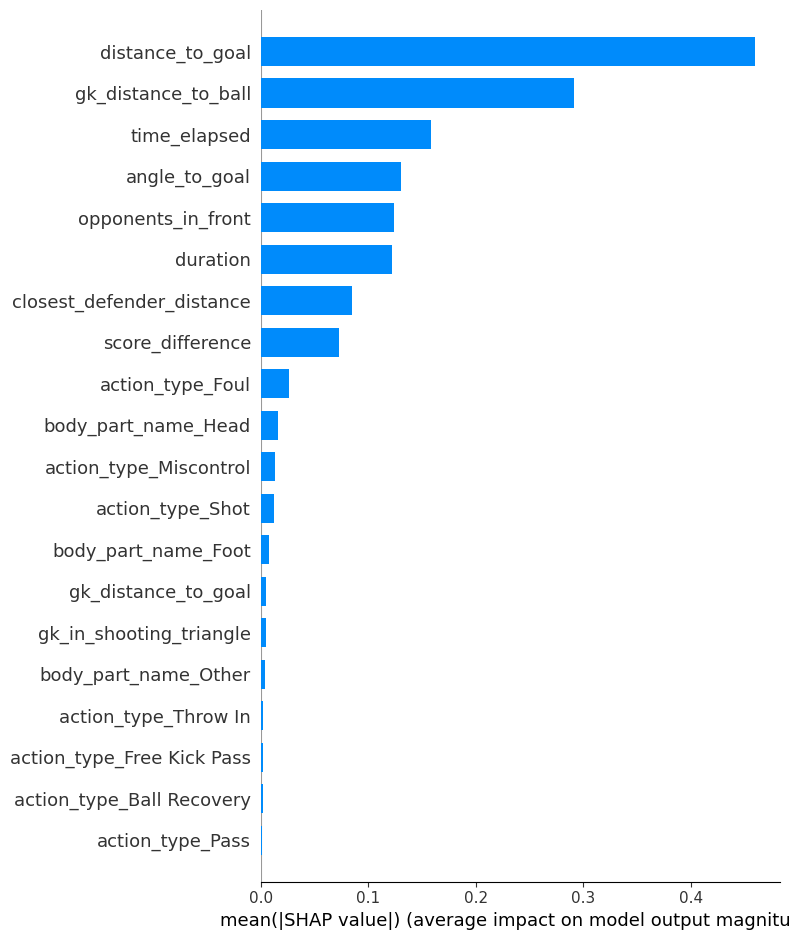

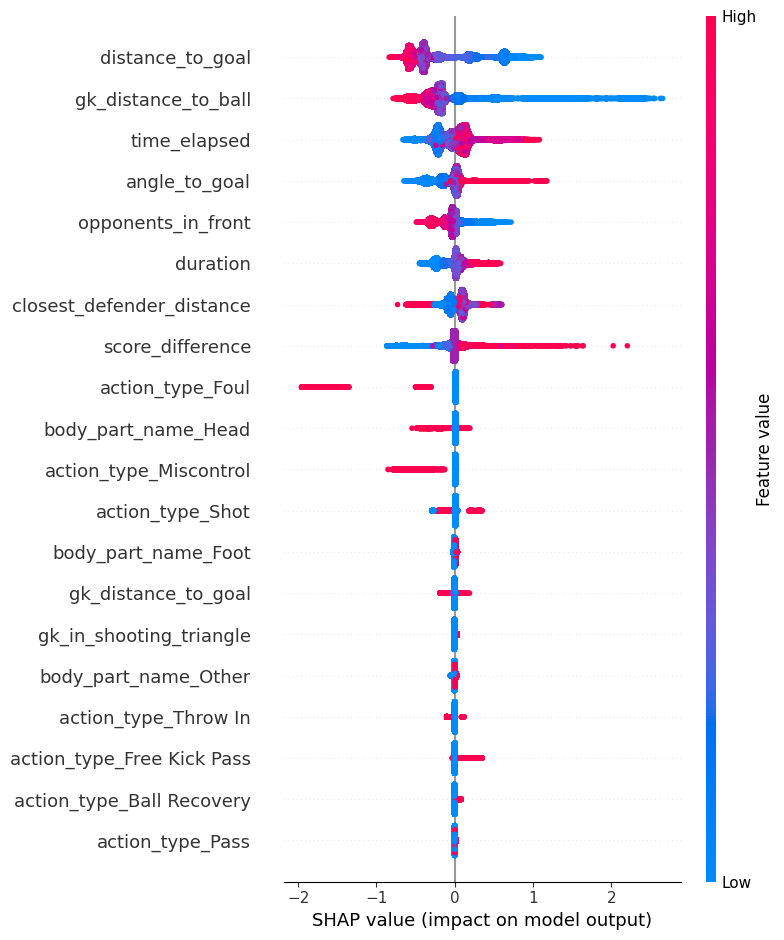

In [329]:
explainer = shap.TreeExplainer(xgb_model)

shap_values = explainer.shap_values(X)

plt.figure()
shap.summary_plot(shap_values, X, plot_type='bar')
plt.title("SHAP Feature Importance (Bar Plot)")
plt.tight_layout()

shap.summary_plot(shap_values, X)

index = 0
shap.initjs()

And for conceding probabilities.

In [330]:
features = ['distance_to_goal_own', 'angle_to_goal_own', 'time_elapsed', 'duration',
        'body_part_name_Foot', 'body_part_name_Head', 'body_part_name_Other',
        'action_type_Ball Recovery', 'action_type_Carry',
        'action_type_Clearance', 'action_type_Corner', 'action_type_Foul',
        'action_type_Free Kick Pass', 'action_type_Free Kick Shot',
        'action_type_Goal Kick', 'action_type_Interception',
        'action_type_Miscontrol', 'action_type_Own Goal', 'action_type_Pass',
        'action_type_Penalty Shot', 'action_type_Shot', 'action_type_Tackle',
        'action_type_Throw In', 'closest_defender_distance', 'gk_distance_to_ball_own', 
        'gk_in_shooting_triangle_own', 'gk_distance_to_goal_own', 'score_difference']

df_model = df_model.dropna(subset=features + [target_opponent])

X_opp = df_model[features]
y_opp = df_model[target_opponent]

X_train_opp, X_test_opp, y_train_opp, y_test_opp = train_test_split(
    X_opp, y_opp, test_size=0.5, stratify=y_opp, random_state=RANDOM_STATE
)

model_opp = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    eval_metric='logloss',
    random_state=RANDOM_STATE
)

model_opp.fit(X_train_opp, y_train_opp)

y_pred_opp = model_opp.predict(X_test_opp)
y_prob_opp = model_opp.predict_proba(X_test_opp)[:, 1]

print("Classification Report (Conceding Goals):")
print(classification_report(y_test_opp, y_pred_opp))
print("ROC AUC Score (Conceding Goals):", roc_auc_score(y_test_opp, y_prob_opp))
print("Brier Score:", brier_score_loss(y_test_opp, y_prob_opp))

df_model = df_model.copy()
y_prob_opp_all = model_opp.predict_proba(X_opp)[:, 1]
df_model['predicted_concede_prob'] = y_prob_opp_all

Classification Report (Conceding Goals):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    223443
           1       1.00      0.03      0.06       465

    accuracy                           1.00    223908
   macro avg       1.00      0.52      0.53    223908
weighted avg       1.00      1.00      1.00    223908

ROC AUC Score (Conceding Goals): 0.8038962331400195
Brier Score: 0.0019494071431526482


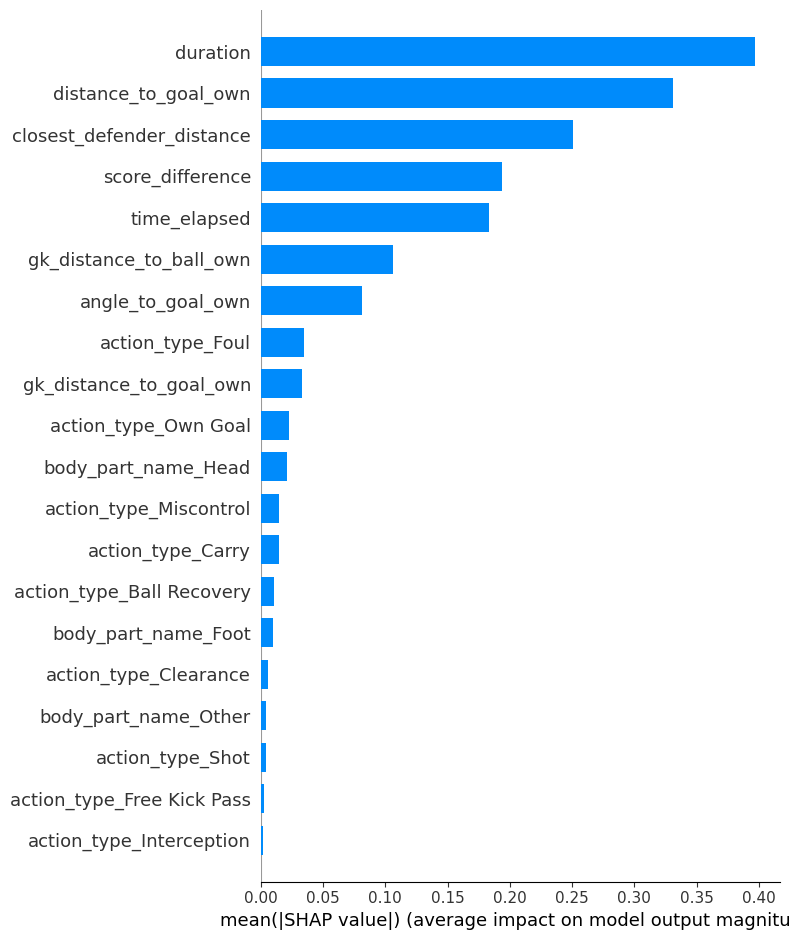

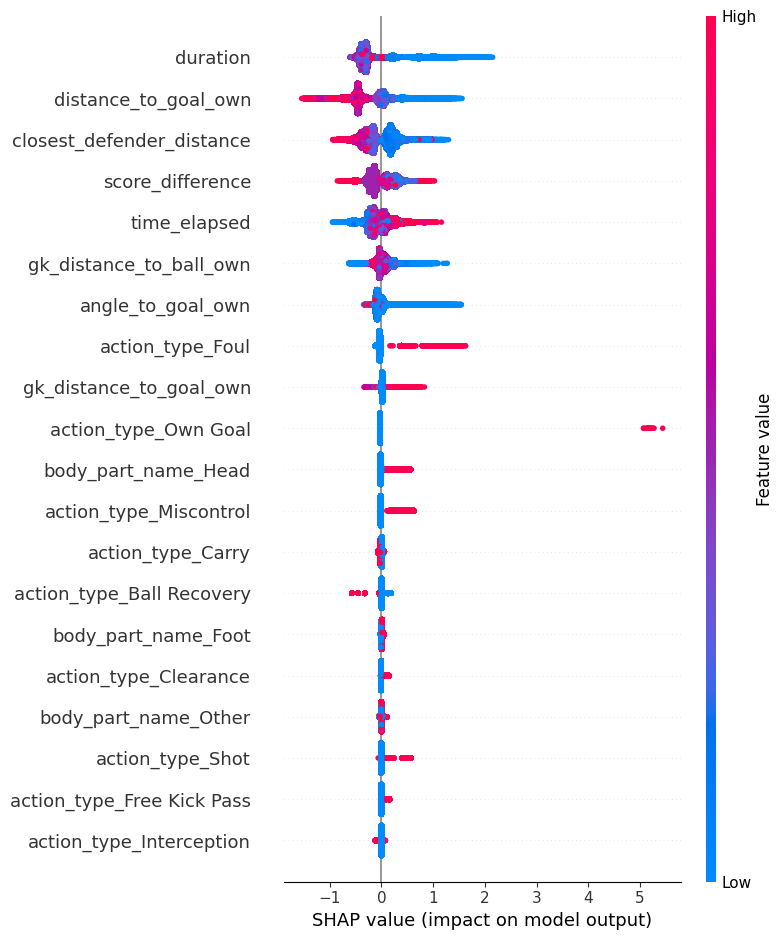

In [331]:
explainer = shap.TreeExplainer(model_opp)

shap_values = explainer.shap_values(X_opp)

plt.figure()
shap.summary_plot(shap_values, X_opp, plot_type='bar')
plt.title("SHAP Feature Importance (Bar Plot)")
plt.tight_layout()

shap.summary_plot(shap_values, X_opp)

index = 0
shap.initjs()

### Computing Action Values ###

Now we can calculate the action value as the sum of differences in scoring and conceding probabilities between subsequent game states. We need to consider two special cases though:

1. When a shot ends up in a goal the next state value will be set to 1. Works analogously for an own goal.
2. When possession changes after an action, the probabilities are switched in the next state, because the scoring and conceding probabilities always        correspond to the team performing the action.

In [332]:
df_model['action_value'] = 0.0

for match_id, df_match in df_model.groupby('match_id', sort=False):
    idxs = df_match.index.to_list()

    for i in range(len(idxs) - 1):
        idx_current = idxs[i]
        idx_next = idxs[i + 1]

        current_team = df_model.at[idx_current, 'team_id']
        next_team = df_model.at[idx_next, 'team_id']

        score_curr = df_model.at[idx_current, 'predicted_goal_prob']
        concede_curr = df_model.at[idx_current, 'predicted_concede_prob']

        score_next = df_model.at[idx_next, 'predicted_goal_prob']
        concede_next = df_model.at[idx_next, 'predicted_concede_prob']

        goal_scored = (
            df_model.at[idx_current, 'type_name'] == 'Shot' and
            df_model.at[idx_current, 'outcome_name'] == 'Goal'
        )

        own_goal_scored = (
            df_model.at[idx_current, 'type_name'] == 'Own Goal Against'
        )

        if goal_scored:
            score_next = 1.0
            concede_next = 0.0
        elif own_goal_scored:
            score_next = 0.0
            concede_next = 1.0

        if next_team != current_team and not goal_scored and not own_goal_scored:
            score_next, concede_next = concede_next, score_next

        delta_score = score_next - score_curr
        delta_concede = concede_curr - concede_next
        action_value = delta_score + delta_concede

        df_model.at[idx_current, 'action_value'] = action_value


In [333]:
df_model.to_pickle("data/data_cleaned_trained.pkl")

In [334]:
test = df_model[['id', 'index', 'period', 'timestamp', 'match_id', 'type_name', 'team_name', 'player_id', 'player_name',
       'position_id', 'position_name', 'sub_type_name', 'x', 'y', 'predicted_goal_prob', 'predicted_concede_prob', 'action_value',
        'outcome_name', 'result',
       'distance_to_goal', 'distance_to_goal_own', 'angle_to_goal',
       'angle_to_goal_own', 'score_difference', 'closest_defender_distance',
       'opponents_in_front', 'gk_distance_to_ball_own',
       'gk_in_shooting_triangle_own', 'gk_distance_to_goal_own',
       'gk_distance_to_ball', 'gk_in_shooting_triangle', 'gk_distance_to_goal',
       'label_team_goal', 'label_opponent_goal']]

test.to_csv("test.csv")

We can now rank players according to their cumulated action values. However we need to normalize the action values to per 90 minutes to make the ranking fair. To do this we need to get the playing time of each player in the dataset.

In [335]:
player_minutes = pd.read_pickle("data/player_minutes.pkl")

top_players_df = df_model.groupby(['player_id', 'player_name'])['action_value'].sum().reset_index()

top_players_df = top_players_df.merge(
    player_minutes[['player_id', 'minutes_played']],
    on='player_id',
    how='left'
)

MIN_MINUTES = 270
top_players_df = top_players_df[top_players_df['minutes_played'] >= MIN_MINUTES]
top_players_df['action_value_per90'] = top_players_df['action_value'] / (top_players_df['minutes_played'] / 90)

top_players_df = top_players_df.sort_values(by='action_value_per90', ascending=False)
print(top_players_df[['player_name', 'action_value_per90']].head(30))

                                  player_name  action_value_per90
1508              Lamine Yamal Nasraoui Ebana            0.692349
81                            Xherdan Shaqiri            0.680316
489                                Ritsu Doan            0.659581
233            Lionel Andrés Messi Cuccittini            0.658416
1034                             Ivan Schranz            0.657621
235                       Jens Stryger Larsen            0.656452
287                       Emil Peter Forsberg            0.611417
189                          Jordi Alba Ramos            0.574285
1419                               Arda Güler            0.558322
885                         Cody Mathès Gakpo            0.530539
350                      Pablo Sarabia García            0.511406
1061             Luis Gerardo Chávez Magallón            0.492424
634                 Alejandro Grimaldo García            0.491788
872                                Paul Pogba            0.468542
1076      